In this notebook the prepared data will be visualised.

Still TODO: 
- Quantify the speech so that it can visualise something meaningful. 
- Use modeling, but Problem: Languages?
- Think about what plots would suit the current question and hypotheses the best, e.g., histogram?
- Instead of Git link use provided UNSD to go from alpha-2 -> alpha-3
- Add some recent speeches


Paper about the topic:
https://s3.us-east-1.amazonaws.com/climate-change-ai/papers/neurips2020/69/paper.pdf

#### 0. Prepare the data

##### a) Load the daset containing the speeches

In [46]:
import os
import numpy as np
import pandas as pd

sessions = np.arange(25, 76)
data = []

for session in sessions:
    directory = "./TXT/Session " + str(session) + " - " + str(1945 + session)
    for filename in os.listdir(directory):
        f = open(os.path.join(directory, filename))
        if filename[0] == ".": #ignore hidden files
            continue
        splt = filename.split("_")
        # Start from '95
        if session < 50:
            continue
        data.append([session, 1945 + session, splt[0], f.read()])

df_speech = pd.DataFrame(data, columns=['Session','Year','ISO-alpha3 Code','Speech'])
df_speech.head() # Shape: (4913, 4)

,Session,Year,ISO-alpha3 Code,Speech
0,50,1995,BDI,The United Nations is celebrating its fiftieth...
1,50,1995,VNM,"Allow me at the outset, on behalf of the\ndele..."
2,50,1995,PAK,"I extend to you, Sir, my\ndelegation’s felicit..."
3,50,1995,MLI,We\nare meeting on the eve of the fiftieth ann...
4,50,1995,FRA,"Mr. President, I should like to say first how\..."


##### b) Load the dataset containing the expenses

In [89]:
# Load COFOG
cofog = pd.read_csv("data/gov_10a_exp__custom_3469207_page_tabular.tsv", sep='\t')

cofog.iloc[:,0] = cofog.iloc[:,0].str.split(',').str[-1]
cofog.rename(columns={cofog.columns[0]: "ISO-alpha2 Code"}, inplace=True)

# Perform some preprocessing
cofog = cofog.melt(id_vars=["ISO-alpha2 Code"], var_name="Year", value_name='Expenses')
cofog['Year'] = cofog['Year'].astype(int)
cofog['Expenses'] = cofog['Expenses'].astype(str).str.strip().str.extract(r'(\d+.\d+)').astype('float')

cofog.head()


,ISO-alpha2 Code,Year,Expenses
0,AT,1995,55.8
1,BE,1995,52.6
2,BG,1995,31.7
3,CH,1995,33.3
4,CY,1995,30.9


COFOG contains ISO-alpha2 Code while `df_speeches` has ISO-alpha3 codes. We can use another external dataset that uses both.

##### c) Load dataset containing all names of countries and codes

In [91]:
df_codes = pd.read_csv("data/UNSD — Methodology.csv", delimiter=';')

df_un_merged = cofog.merge(df_codes, how='inner') #dataset goes from 832->754, don't know why!!!
df_un_merged = df_un_merged[["ISO-alpha3 Code", "ISO-alpha2 Code", "Expenses", "Country or Area", "Year", "Region Name", "Sub-region Name"]]

df_un_merged.head()


,ISO-alpha3 Code,ISO-alpha2 Code,Expenses,Country or Area,Year,Region Name,Sub-region Name
0,AUT,AT,55.8,Austria,1995,Europe,Western Europe
1,AUT,AT,55.6,Austria,1996,Europe,Western Europe
2,AUT,AT,52.3,Austria,1997,Europe,Western Europe
3,AUT,AT,52.2,Austria,1998,Europe,Western Europe
4,AUT,AT,52.1,Austria,1999,Europe,Western Europe


Now we have a COFOG dataframe and a speeches which can be merged with the corresponding `ISO-alpha3` codes and the specific year. We also remove non-European countries.

In [95]:
df_speech = df_speech.merge(df_un_merged, how='inner', on=['Year', 'ISO-alpha3 Code'])
df_speech.head()

,Session,Year,ISO-alpha3 Code,Speech,ISO-alpha2 Code,Expenses,Country or Area,Region Name,Sub-region Name
0,50,1995,FRA,"Mr. President, I should like to say first how\...",FR,54.8,France,Europe,Western Europe
1,50,1995,IRL,I warmly congratulate the\nPresident on his el...,IE,40.4,Ireland,Europe,Northern Europe
2,50,1995,BEL,“[Today more then ever we should realize that\...,BE,52.6,Belgium,Europe,Western Europe
3,50,1995,ISL,"Mr. President, may I\ncongratulate you on your...",IS,NaN,Iceland,Europe,Northern Europe
4,50,1995,HUN,"May I extend our\ncongratulations to you, Sir,...",HU,55.2,Hungary,Europe,Eastern Europe


Next, we need to know how much 'attention' the Member States give environmental issues in their speeches.
This means we will need to convert Speech to a quantative variable in a way. We could do this with sentence-based climate change topic detection. Every sentence would need to be classified as being about climate change or not. We can use the following paper: https://s3.us-east-1.amazonaws.com/climate-change-ai/papers/neurips2020/69/paper.pdf and the corresponding dataset https://www.sustainablefinance.uzh.ch/en/research/climate-fever.html and following tutorial https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

In [163]:
from sklearn.model_selection import train_test_split

# Loading the labeled dataset to be usd for training
climate = pd.read_json('data/climate-fever-dataset-r1.jsonl', lines=True) # Source https://www.sustainablefinance.uzh.ch/en/research/climate-fever.html

# Split data in seperate sets
X_train, X_test, y_train, y_test = train_test_split(climate.claim, climate.claim_label,\
    test_size=0.33, random_state=42)

Pipeline includes: tokenizing, counting occurencies, tfidf

In [184]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Training a classifier
climate_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

climate_clf.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [185]:
import numpy as np

# Evaluation
predicted = climate_clf.predict(X_test)

np.mean(predicted == y_test)

0.46745562130177515

#### 2. Visualisation

Remember the principles of data visualisation: 
1. Know the audience: Curse of expertise, informative labels.
2. One plot, one message.
3. Adapt figure to medium: Thicker lines, less information for smaller mediums.
4. Caption! 
5. Do not trust the defaults (especially in Matplotlib)
6. Use color effectively. Color maps: sequential vs diverging vs qualitative.

    *Diverging* = if there’s a meaningful middle point
    
    *Sequential* = for a more intuitive reading
7. Avoid chartjunk = unnecessary visual elements
8. Do not mislead audience
9. Chose message over beauty
10. Know and use the right tool: matplotlib, seaborn, geopandas, networkX.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set styling parameters for sns
sns.set_theme(); sns.set_context('notebook'); sns.set_style('ticks')

x = df_speech['Year'].values
y = df_speech['Expenses'].values

Linegraph

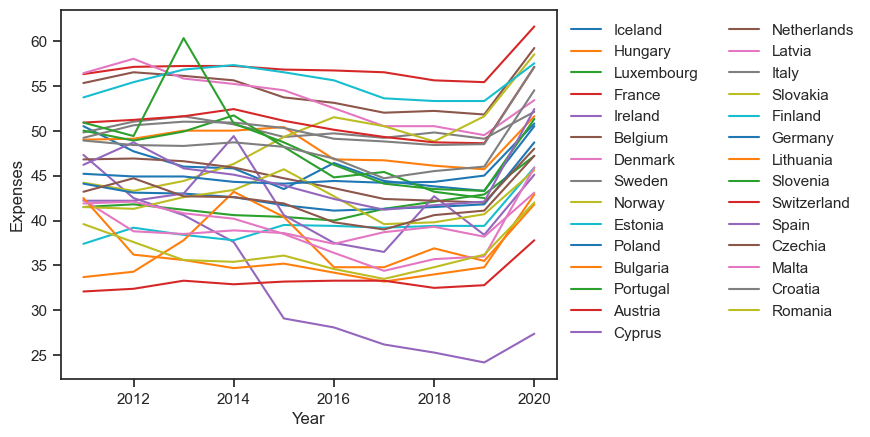

In [177]:
#TODO Plot lingraph: X = Year, Y = Expenses, Lines = Different countries

ax = sns.lineplot(x="Year", y="Expenses", hue='name', data=df_speech, palette='tab10')
ax.legend(ncol=2, bbox_to_anchor=(1, 1), frameon=False)

Scatterplot

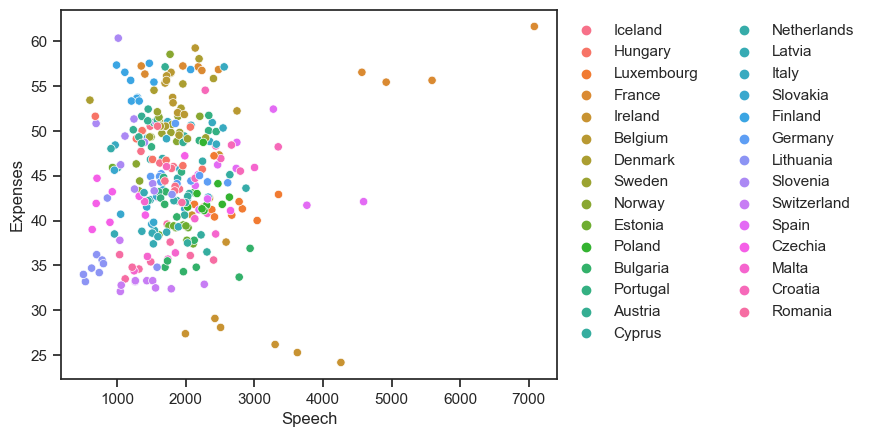

In [178]:
# TODO Scatterplot: X = Year, Y = Expenses, Dot = Country
ax = sns.scatterplot(x="Speech", y="Expenses", hue='name', data=df_speech)
ax.legend(ncol=2, bbox_to_anchor=(1, 1), frameon=False)

Histogram

In [ ]:
#TODO Plot histogram: group data by ISO, 

Geopandas

<AxesSubplot: >

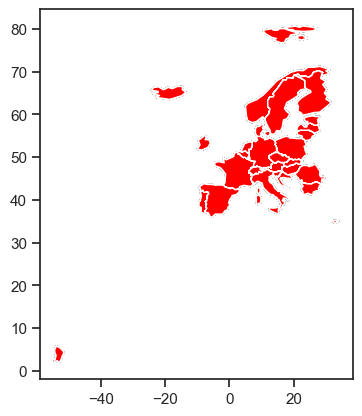

In [201]:
import geopandas

world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
world = world.merge(df_speech, how='inner', on='name')


ax = world.plot(color='white', edgecolor='black')
world.plot(ax=ax, color='red')